# Fe-Ni-V

## Run feasibility tests on a ternary system with a plot


Imports

In [1]:
import os
import matplotlib.pyplot as plt
from pycalphad import Database, variables as v
from analysis_runner import run_simulation, plot_figure, EquilibriumSamplingPointsGenerator

T_liquid = 2200  # temperature where everything is liquid
potentials = {v.N: 1, v.T: (1000, T_liquid, 10), v.P: 101325}  # for equilibrium calculations
ngridpts = 41  # number of points along each dimension of the composition grid
tolerance_deleterious_phases = 0.10  # Maximum tolerance for deleterious phases
OUTDIR = 'figures'

# Global setup
plt.style.use('papers.mplstyle')
try:
    os.mkdir(OUTDIR)
except FileExistsError:
    pass


In [2]:
dbf = Database(os.path.join('..', 'databases', 'Fe-Ni-V_zhao2014.tdb'))
comps = ['FE', 'NI', 'V', 'VA']
phases = list(dbf.phases.keys())
allowed_phases = ['LIQUID', 'BCC_A2', 'FCC_A1', 'HCP_A3']  # phases that are okay to have (non-deleterious)
liquid_phase_name = 'LIQUID'
points_generator = EquilibriumSamplingPointsGenerator(dbf, comps, phases)

/Users/brandon/Projects/Calphad/pycalphad/pycalphad/io/tdb.py:297: UserWarning: The type definition character `&` in `TYPE_DEFINITION & GES A_P_D A2_BCC MAGNETIC -1.0 4.00000E-01 ` is not used by any phase.
  warnings.warn(f"The type definition character `{typechar}` in `TYPE_DEFINITION {typechar} {line}` is not used by any phase.")


In [3]:
compositions_list, equilibrium_results, scheil_results = run_simulation(dbf, comps, phases, potentials, ngridpts, T_liquid, points_generator=points_generator, show_progress=True)

Generating points... 

/Users/brandon/Projects/Calphad/pycalphad/pycalphad/core/lower_convex_hull.py:145: RuntimeWarning: invalid value encountered in double_scalars
  result_array_GM_values[it.multi_index] = new_energy / molesum


Done.
(1/861) - {X_FE: 0.0, X_NI: 0.0} - Equilibrium time =  4.49 s - Scheil time =  4.02 s 
(2/861) - {X_FE: 0.025, X_NI: 0.0} - Equilibrium time =  4.83 s - Scheil time =  12.71 s 
(3/861) - {X_FE: 0.05, X_NI: 0.0} - Equilibrium time =  4.51 s - Scheil time =  13.41 s 
(4/861) - {X_FE: 0.075, X_NI: 0.0} - Equilibrium time =  4.40 s - Scheil time =  13.94 s 
(5/861) - {X_FE: 0.1, X_NI: 0.0} - Equilibrium time =  4.32 s - Scheil time =  14.38 s 
(6/861) - {X_FE: 0.125, X_NI: 0.0} - Equilibrium time =  4.26 s - Scheil time =  14.31 s 
(7/861) - {X_FE: 0.15, X_NI: 0.0} - Equilibrium time =  4.32 s - Scheil time =  14.63 s 
(8/861) - {X_FE: 0.175, X_NI: 0.0} - Equilibrium time =  4.27 s - Scheil time =  14.70 s 
(9/861) - {X_FE: 0.2, X_NI: 0.0} - Equilibrium time =  4.59 s - Scheil time =  14.95 s 
(10/861) - {X_FE: 0.225, X_NI: 0.0} - Equilibrium time =  4.32 s - Scheil time =  14.74 s 
(11/861) - {X_FE: 0.25, X_NI: 0.0} - Equilibrium time =  4.17 s - Scheil time =  14.77 s 
(12/861) - {

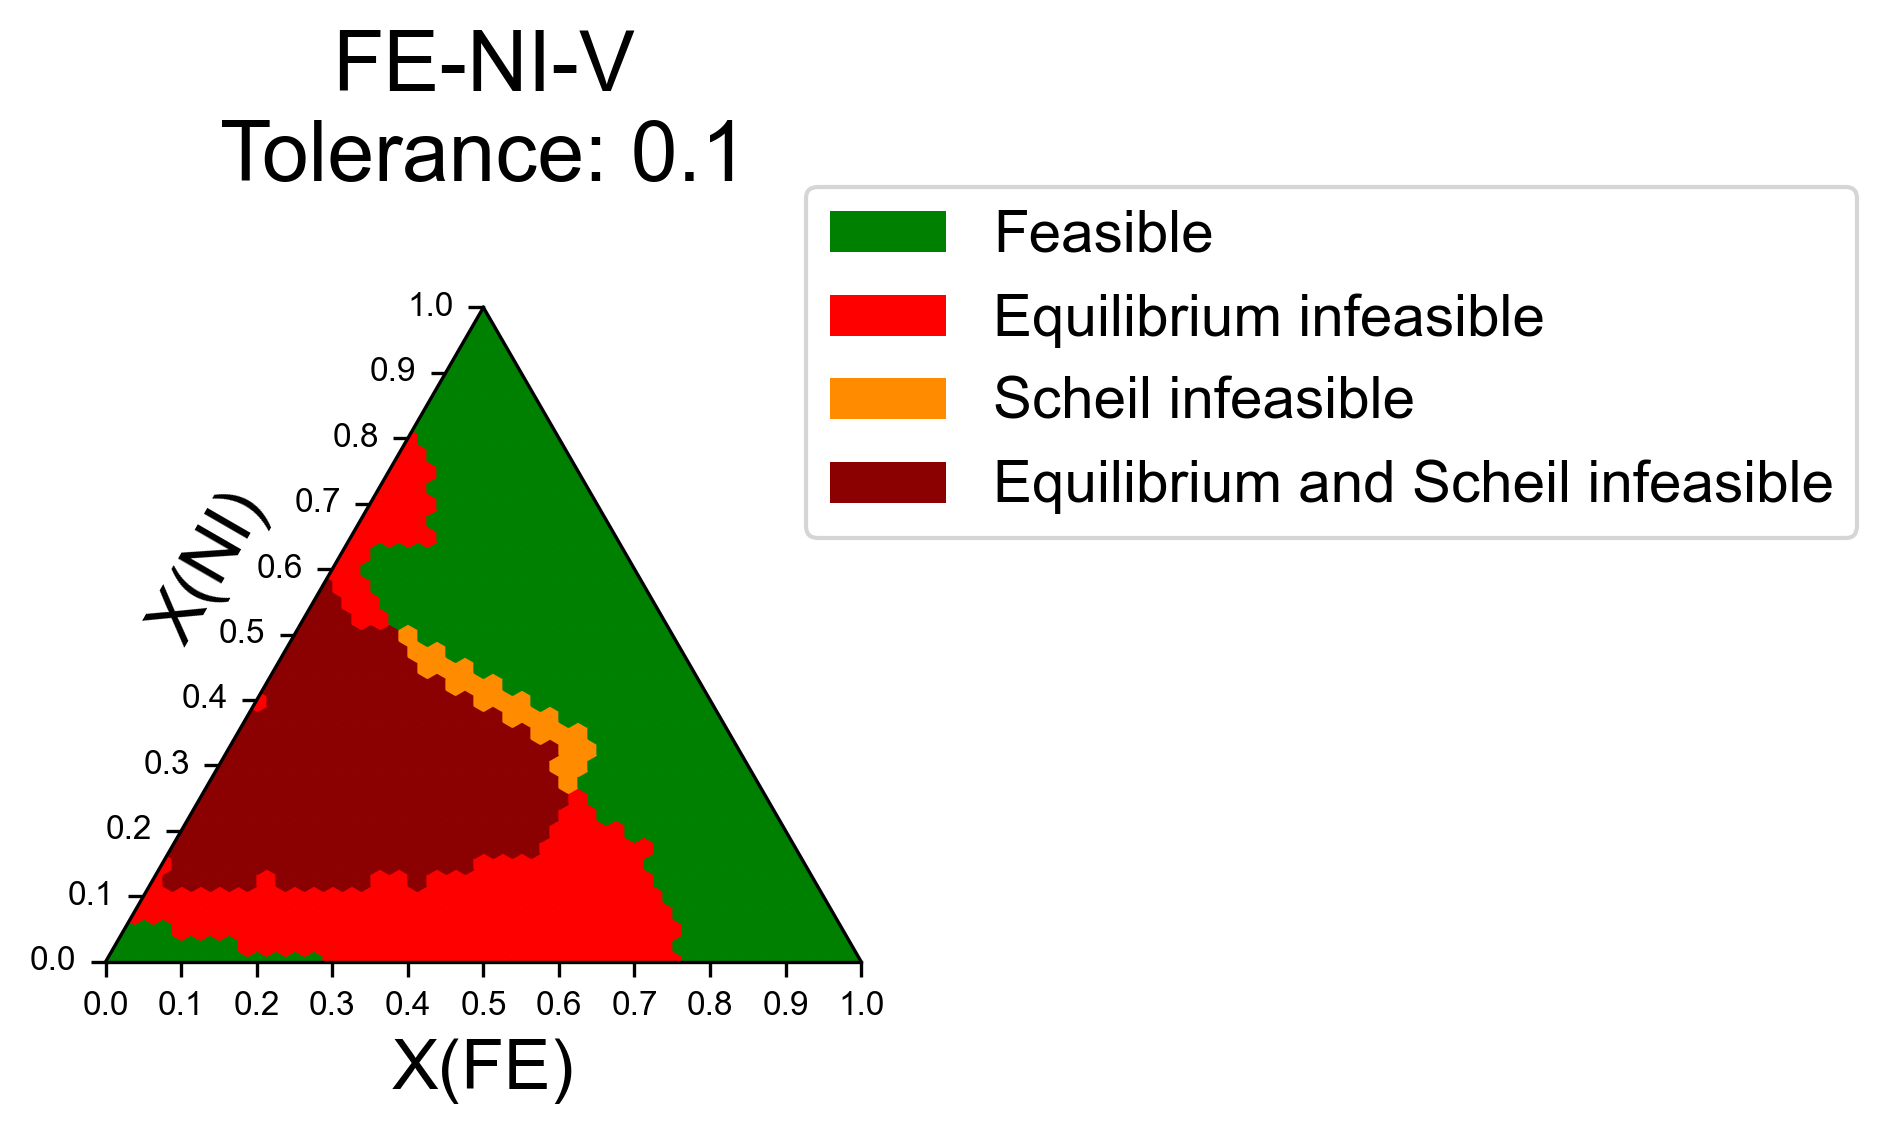

In [9]:
ax = plot_figure(comps, compositions_list, equilibrium_results, scheil_results, allowed_phases, tolerance_deleterious_phases)

ax.figure.savefig(os.path.join(OUTDIR, f"{'-'.join(sorted(set(comps) - {'VA'}))}.pdf"), bbox_inches='tight')

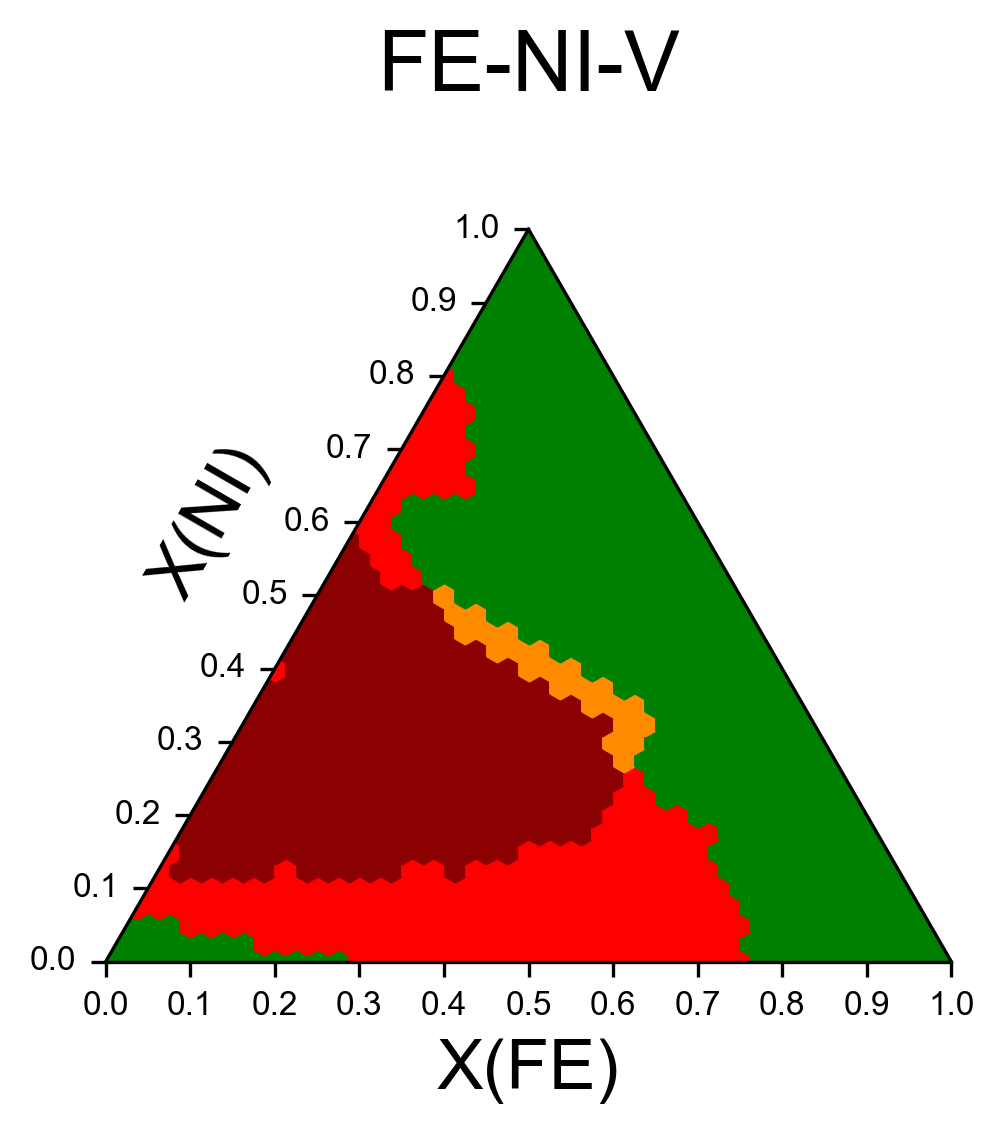

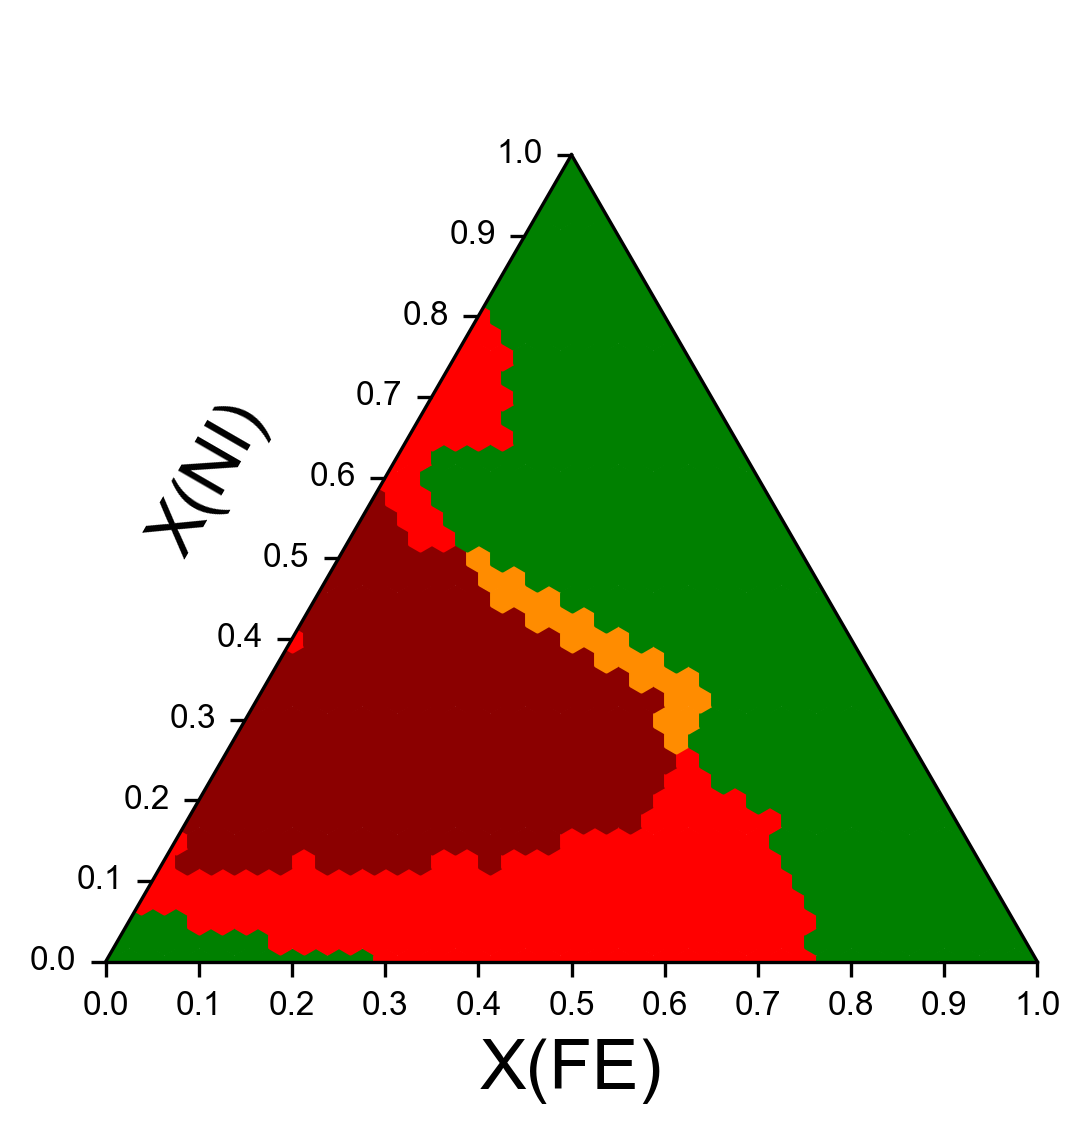

In [10]:
# with title
ax = plot_figure(comps, compositions_list, equilibrium_results, scheil_results, allowed_phases, tolerance_deleterious_phases, scattersize=27)
ax.figure.legends[0].remove()
ax.set_title(f"{'-'.join(sorted(set(comps) - {'VA'}))}")
ax.figure.savefig(os.path.join(OUTDIR, f"{'-'.join(sorted(set(comps) - {'VA'}))}.pdf"), bbox_inches='tight')

# without title
ax = plot_figure(comps, compositions_list, equilibrium_results, scheil_results, allowed_phases, tolerance_deleterious_phases, scattersize=33)
ax.figure.legends[0].remove()
ax.set_title("")
ax.figure.savefig(os.path.join(OUTDIR, f"{'-'.join(sorted(set(comps) - {'VA'}))}-notitle.pdf"), bbox_inches='tight')

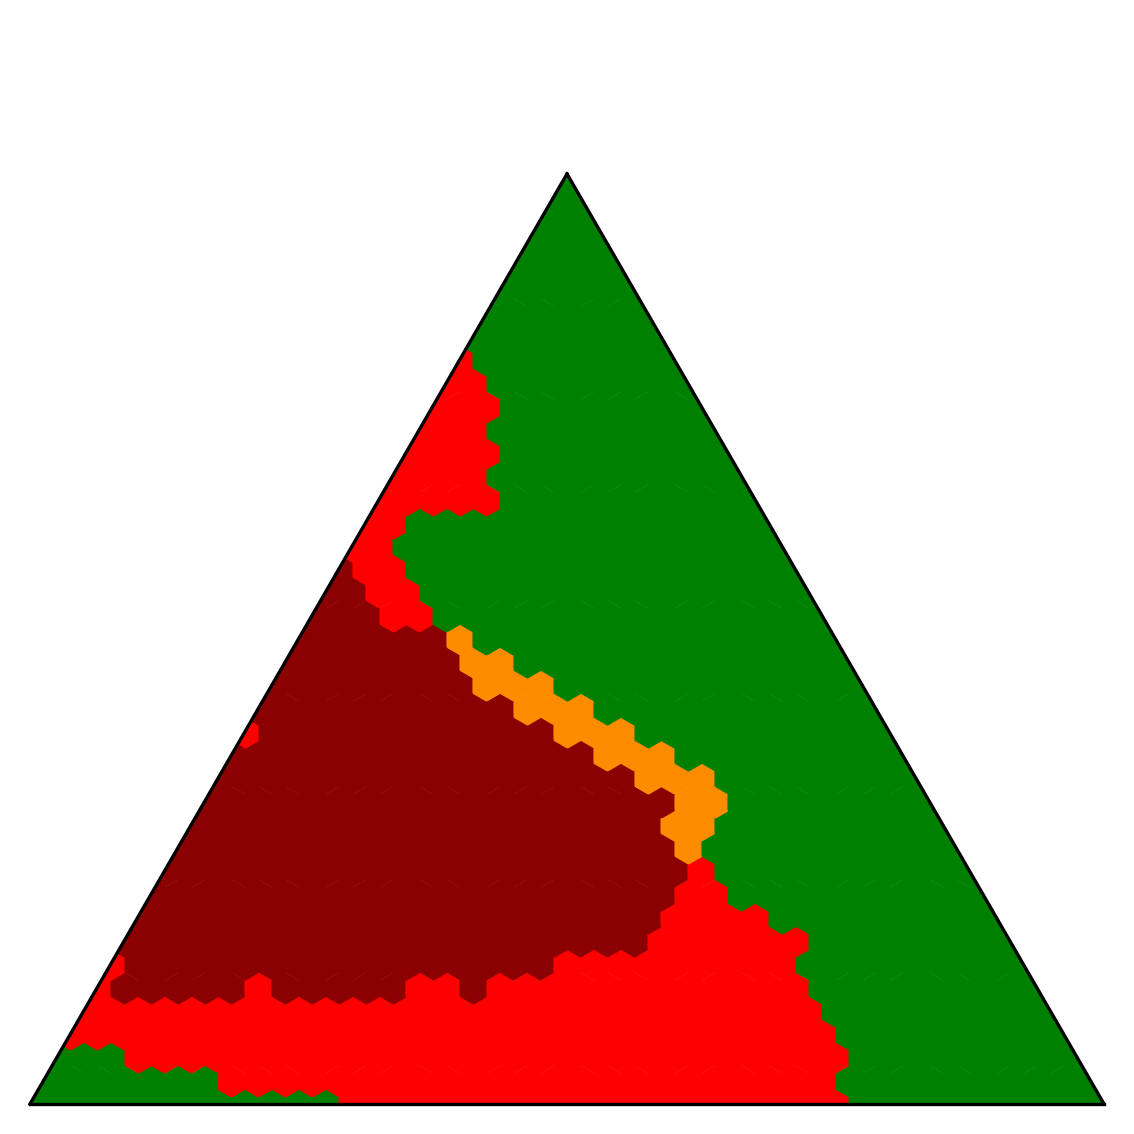

In [11]:
ax = plot_figure(comps, compositions_list, equilibrium_results, scheil_results, allowed_phases, tolerance_deleterious_phases, scattersize=44)
ax.figure.legends[0].remove()
ax.set_title("")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticklabels([])
ax.set_yticks([])
ax.figure.savefig(os.path.join(OUTDIR, f"{'-'.join(sorted(set(comps) - {'VA'}))}-clean.pdf"), bbox_inches='tight')

In [1]:
import os
import time

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from pycalphad import Database, equilibrium, Model, variables as v
from pycalphad.core.calculate import _sample_phase_constitution
from pycalphad.core.utils import point_sample
from scheil import simulate_scheil_solidification
from feasibility_helpers import _build_composition_list, _build_mass_balanced_grid,  get_amount_disallowed_phases, get_amount_disallowed_phases_scheil

## User settings (edit these):
Be careful not to edit the variable names, because they are used below.


In [2]:
DATABASE_DIR = '../databases'
dbf = Database(os.path.join(DATABASE_DIR, 'Fe-Ni-V_zhao2014.tdb'))
comps = ['FE', 'NI', 'V', 'VA']
phases = list(dbf.phases.keys())

T_liquid = 2200  # temperature where everything is liquid
potentials = {v.N: 1, v.T: (1000, T_liquid, 10), v.P: 101325}  # for equilibrium calculations

indep_comps = [comps[1], comps[2]]  # choose them automatically
ngridpts = 11  # number of points along each dimension of the composition grid

allowed_phases = ['LIQUID', 'BCC_A2', 'FCC_A1', 'HCP_A3']  # phases that are okay to have (non-deleterious)
liquid_phase_name = 'LIQUID'
tolerance_deleterious_phases = 0.10  # Maximum tolerance for deleterious phases

SAVE_TIME = True  # If true, don't perform more expensive feasibility tests (e.g. Scheil) if the composition is already known to be infeasible (e.g. from equilibrium)
OUTDIR = 'figures'

/Users/brandon/Projects/Calphad/pycalphad/pycalphad/io/tdb.py:297: UserWarning: The type definition character `&` in `TYPE_DEFINITION & GES A_P_D A2_BCC MAGNETIC -1.0 4.00000E-01 ` is not used by any phase.
  warnings.warn(f"The type definition character `{typechar}` in `TYPE_DEFINITION {typechar} {line}` is not used by any phase.")


In [3]:
## For users: sanity check that T_liquid is in fact liquid at every composition

conds = {v.P: 101325, v.N: 1, v.T: T_liquid, v.X(comps[0]): (0, 1, 0.02), v.X(comps[1]): (0, 1, 0.02)}
eq_res = equilibrium(dbf, comps, phases, conds)
non_liquid_phases = sorted(set(map(str, set(eq_res.Phase.where(~eq_res.Phase.isin([liquid_phase_name, ''])).values.flatten().tolist()))) - {'nan'})
assert len(non_liquid_phases) == 0, f"Got non-liquid phases {non_liquid_phases} at {T_liquid}"

## Script (should not need editing)

Setup

In [4]:
try:
    os.mkdir(OUTDIR)
except FileExistsError:
    pass
plt.style.use('papers.mplstyle')

# Generate points for adaptive Scheil starting points (performance)
points_dict = {}
for phase_name in phases:
    mod = Model(dbf, comps, phase_name)
    points_dict[phase_name] = _sample_phase_constitution(mod, point_sample, True, 50)

# Build compositions to simulate over
grid_comps = _build_mass_balanced_grid(len(indep_comps), ngridpts)
compositions_list = _build_composition_list(indep_comps, grid_comps)

Run simulations

In [5]:
# Run simulations
eq_results = []  # List[xarray.Dataset]
scheil_results = []  # List[Optional[scheil.SolidificationResult]]
for composition in compositions_list:
    print(composition)
    # Equilibrium calculation for feasibility
    conds = {v.P: 101325, v.N: 1, v.T: (1000, 2200, 10), **composition}
    tick = time.time()
    eq_res = equilibrium(dbf, comps, phases, conds)
    tock = time.time()
    eq_results.append(eq_res)
    eq_is_feasible = get_amount_disallowed_phases(eq_res, allowed_phases).max() < tolerance_deleterious_phases
    print(f'Equilibrium time: {tock - tick: 0.2f} s - {"feasible" if eq_is_feasible else "infeasible"}')

    if SAVE_TIME and not eq_is_feasible:
        scheil_results.append(None)  # ensure that the shapes of the results line up, even if we don't do this calculation
        continue
    # Scheil
    tick = time.time()
    sol_res = simulate_scheil_solidification(dbf, comps, phases, composition, T_liquid, adaptive=True, eq_kwargs={'calc_opts': {'points': points_dict}}, liquid_phase_name=liquid_phase_name)
    tock = time.time()
    scheil_results.append(sol_res)
    scheil_is_feasible = get_amount_disallowed_phases_scheil(sol_res, allowed_phases) < tolerance_deleterious_phases
    print(f'Scheil time: {tock - tick: 0.2f} s - {"feasible" if scheil_is_feasible else "infeasible"}')

print('Done simulating')

{X_NI: 0.0001, X_V: 0.0001}
Equilibrium time:  1.84 s - feasible


/Users/brandon/Projects/Calphad/pycalphad/pycalphad/core/utils.py:157: FutureWarning: generate_dof is deprecated and will be removed in a future version of pycalphad. The correct way to determine the degrees of freedom of a particular 'active' phase is to use Model.constituents.
  warnings.warn(msg, FutureWarning)


Scheil time:  379.60 s - feasible
{X_NI: 0.10007, X_V: 0.0001}
Equilibrium time:  1.66 s - feasible


/Users/brandon/Projects/Calphad/pycalphad/pycalphad/core/utils.py:157: FutureWarning: generate_dof is deprecated and will be removed in a future version of pycalphad. The correct way to determine the degrees of freedom of a particular 'active' phase is to use Model.constituents.
  warnings.warn(msg, FutureWarning)


Scheil time:  408.70 s - feasible
{X_NI: 0.20004, X_V: 0.0001}
Equilibrium time:  1.94 s - feasible


/Users/brandon/Projects/Calphad/pycalphad/pycalphad/core/utils.py:157: FutureWarning: generate_dof is deprecated and will be removed in a future version of pycalphad. The correct way to determine the degrees of freedom of a particular 'active' phase is to use Model.constituents.
  warnings.warn(msg, FutureWarning)


Scheil time:  445.44 s - feasible
{X_NI: 0.30001, X_V: 0.0001}
Equilibrium time:  2.06 s - feasible


/Users/brandon/Projects/Calphad/pycalphad/pycalphad/core/utils.py:157: FutureWarning: generate_dof is deprecated and will be removed in a future version of pycalphad. The correct way to determine the degrees of freedom of a particular 'active' phase is to use Model.constituents.
  warnings.warn(msg, FutureWarning)


Scheil time:  549.19 s - feasible
{X_NI: 0.39998, X_V: 0.0001}
Equilibrium time:  2.08 s - feasible


/Users/brandon/Projects/Calphad/pycalphad/pycalphad/core/utils.py:157: FutureWarning: generate_dof is deprecated and will be removed in a future version of pycalphad. The correct way to determine the degrees of freedom of a particular 'active' phase is to use Model.constituents.
  warnings.warn(msg, FutureWarning)


Scheil time:  552.31 s - feasible
{X_NI: 0.49995, X_V: 0.0001}
Equilibrium time:  2.04 s - feasible


/Users/brandon/Projects/Calphad/pycalphad/pycalphad/core/utils.py:157: FutureWarning: generate_dof is deprecated and will be removed in a future version of pycalphad. The correct way to determine the degrees of freedom of a particular 'active' phase is to use Model.constituents.
  warnings.warn(msg, FutureWarning)


Scheil time:  538.48 s - feasible
{X_NI: 0.59992, X_V: 0.0001}
Equilibrium time:  2.00 s - feasible


/Users/brandon/Projects/Calphad/pycalphad/pycalphad/core/utils.py:157: FutureWarning: generate_dof is deprecated and will be removed in a future version of pycalphad. The correct way to determine the degrees of freedom of a particular 'active' phase is to use Model.constituents.
  warnings.warn(msg, FutureWarning)


Scheil time:  482.57 s - feasible
{X_NI: 0.69989, X_V: 0.0001}
Equilibrium time:  1.85 s - feasible


/Users/brandon/Projects/Calphad/pycalphad/pycalphad/core/utils.py:157: FutureWarning: generate_dof is deprecated and will be removed in a future version of pycalphad. The correct way to determine the degrees of freedom of a particular 'active' phase is to use Model.constituents.
  warnings.warn(msg, FutureWarning)


Scheil time:  481.86 s - feasible
{X_NI: 0.79986, X_V: 0.0001}
Equilibrium time:  2.02 s - feasible


/Users/brandon/Projects/Calphad/pycalphad/pycalphad/core/utils.py:157: FutureWarning: generate_dof is deprecated and will be removed in a future version of pycalphad. The correct way to determine the degrees of freedom of a particular 'active' phase is to use Model.constituents.
  warnings.warn(msg, FutureWarning)


Scheil time:  475.46 s - feasible
{X_NI: 0.89983, X_V: 0.0001}
Equilibrium time:  2.09 s - feasible


/Users/brandon/Projects/Calphad/pycalphad/pycalphad/core/utils.py:157: FutureWarning: generate_dof is deprecated and will be removed in a future version of pycalphad. The correct way to determine the degrees of freedom of a particular 'active' phase is to use Model.constituents.
  warnings.warn(msg, FutureWarning)


Scheil time:  475.01 s - feasible
{X_NI: 0.9998, X_V: 0.0001}
Equilibrium time:  1.94 s - feasible


/Users/brandon/Projects/Calphad/pycalphad/pycalphad/core/utils.py:157: FutureWarning: generate_dof is deprecated and will be removed in a future version of pycalphad. The correct way to determine the degrees of freedom of a particular 'active' phase is to use Model.constituents.
  warnings.warn(msg, FutureWarning)


Scheil time:  487.47 s - feasible
{X_NI: 0.0001, X_V: 0.10007}
Equilibrium time:  1.96 s - feasible


/Users/brandon/Projects/Calphad/pycalphad/pycalphad/core/utils.py:157: FutureWarning: generate_dof is deprecated and will be removed in a future version of pycalphad. The correct way to determine the degrees of freedom of a particular 'active' phase is to use Model.constituents.
  warnings.warn(msg, FutureWarning)


Scheil time:  438.61 s - feasible
{X_NI: 0.10007, X_V: 0.10007}
Equilibrium time:  2.01 s - feasible


/Users/brandon/Projects/Calphad/pycalphad/pycalphad/core/utils.py:157: FutureWarning: generate_dof is deprecated and will be removed in a future version of pycalphad. The correct way to determine the degrees of freedom of a particular 'active' phase is to use Model.constituents.
  warnings.warn(msg, FutureWarning)


Scheil time:  626.80 s - feasible
{X_NI: 0.20004, X_V: 0.10007}
Equilibrium time:  1.87 s - feasible


/Users/brandon/Projects/Calphad/pycalphad/pycalphad/core/utils.py:157: FutureWarning: generate_dof is deprecated and will be removed in a future version of pycalphad. The correct way to determine the degrees of freedom of a particular 'active' phase is to use Model.constituents.
  warnings.warn(msg, FutureWarning)


Scheil time:  635.78 s - feasible
{X_NI: 0.30001, X_V: 0.10007}
Equilibrium time:  1.91 s - feasible


/Users/brandon/Projects/Calphad/pycalphad/pycalphad/core/utils.py:157: FutureWarning: generate_dof is deprecated and will be removed in a future version of pycalphad. The correct way to determine the degrees of freedom of a particular 'active' phase is to use Model.constituents.
  warnings.warn(msg, FutureWarning)


Scheil time:  640.54 s - feasible
{X_NI: 0.39998, X_V: 0.10007}
Equilibrium time:  2.27 s - feasible


/Users/brandon/Projects/Calphad/pycalphad/pycalphad/core/utils.py:157: FutureWarning: generate_dof is deprecated and will be removed in a future version of pycalphad. The correct way to determine the degrees of freedom of a particular 'active' phase is to use Model.constituents.
  warnings.warn(msg, FutureWarning)


Scheil time:  645.71 s - feasible
{X_NI: 0.49995, X_V: 0.10007}
Equilibrium time:  1.95 s - feasible


/Users/brandon/Projects/Calphad/pycalphad/pycalphad/core/utils.py:157: FutureWarning: generate_dof is deprecated and will be removed in a future version of pycalphad. The correct way to determine the degrees of freedom of a particular 'active' phase is to use Model.constituents.
  warnings.warn(msg, FutureWarning)


Scheil time:  651.90 s - feasible
{X_NI: 0.59992, X_V: 0.10007}
Equilibrium time:  1.80 s - feasible


/Users/brandon/Projects/Calphad/pycalphad/pycalphad/core/utils.py:157: FutureWarning: generate_dof is deprecated and will be removed in a future version of pycalphad. The correct way to determine the degrees of freedom of a particular 'active' phase is to use Model.constituents.
  warnings.warn(msg, FutureWarning)


Scheil time:  664.07 s - feasible
{X_NI: 0.69989, X_V: 0.10007}
Equilibrium time:  1.93 s - infeasible
{X_NI: 0.79986, X_V: 0.10007}
Equilibrium time:  1.76 s - feasible


/Users/brandon/Projects/Calphad/pycalphad/pycalphad/core/utils.py:157: FutureWarning: generate_dof is deprecated and will be removed in a future version of pycalphad. The correct way to determine the degrees of freedom of a particular 'active' phase is to use Model.constituents.
  warnings.warn(msg, FutureWarning)


Scheil time:  583.90 s - feasible
{X_NI: 0.89983, X_V: 0.10007}
Equilibrium time:  1.88 s - feasible


/Users/brandon/Projects/Calphad/pycalphad/pycalphad/core/utils.py:157: FutureWarning: generate_dof is deprecated and will be removed in a future version of pycalphad. The correct way to determine the degrees of freedom of a particular 'active' phase is to use Model.constituents.
  warnings.warn(msg, FutureWarning)


Scheil time:  497.42 s - feasible
{X_NI: 0.0001, X_V: 0.20004}
Equilibrium time:  1.84 s - feasible


/Users/brandon/Projects/Calphad/pycalphad/pycalphad/core/utils.py:157: FutureWarning: generate_dof is deprecated and will be removed in a future version of pycalphad. The correct way to determine the degrees of freedom of a particular 'active' phase is to use Model.constituents.
  warnings.warn(msg, FutureWarning)


Scheil time:  452.90 s - feasible
{X_NI: 0.10007, X_V: 0.20004}
Equilibrium time:  2.00 s - feasible


/Users/brandon/Projects/Calphad/pycalphad/pycalphad/core/utils.py:157: FutureWarning: generate_dof is deprecated and will be removed in a future version of pycalphad. The correct way to determine the degrees of freedom of a particular 'active' phase is to use Model.constituents.
  warnings.warn(msg, FutureWarning)


Scheil time:  642.37 s - feasible
{X_NI: 0.20004, X_V: 0.20004}
Equilibrium time:  2.06 s - feasible


/Users/brandon/Projects/Calphad/pycalphad/pycalphad/core/utils.py:157: FutureWarning: generate_dof is deprecated and will be removed in a future version of pycalphad. The correct way to determine the degrees of freedom of a particular 'active' phase is to use Model.constituents.
  warnings.warn(msg, FutureWarning)


Scheil time:  650.96 s - feasible
{X_NI: 0.30001, X_V: 0.20004}
Equilibrium time:  1.94 s - feasible


/Users/brandon/Projects/Calphad/pycalphad/pycalphad/core/utils.py:157: FutureWarning: generate_dof is deprecated and will be removed in a future version of pycalphad. The correct way to determine the degrees of freedom of a particular 'active' phase is to use Model.constituents.
  warnings.warn(msg, FutureWarning)


Scheil time:  644.97 s - feasible
{X_NI: 0.39998, X_V: 0.20004}
Equilibrium time:  1.85 s - feasible


/Users/brandon/Projects/Calphad/pycalphad/pycalphad/core/utils.py:157: FutureWarning: generate_dof is deprecated and will be removed in a future version of pycalphad. The correct way to determine the degrees of freedom of a particular 'active' phase is to use Model.constituents.
  warnings.warn(msg, FutureWarning)


Scheil time:  624.96 s - feasible
{X_NI: 0.49995, X_V: 0.20004}
Equilibrium time:  1.69 s - feasible


/Users/brandon/Projects/Calphad/pycalphad/pycalphad/core/utils.py:157: FutureWarning: generate_dof is deprecated and will be removed in a future version of pycalphad. The correct way to determine the degrees of freedom of a particular 'active' phase is to use Model.constituents.
  warnings.warn(msg, FutureWarning)


Scheil time:  630.14 s - feasible
{X_NI: 0.59992, X_V: 0.20004}
Equilibrium time:  8.56 s - infeasible
{X_NI: 0.69989, X_V: 0.20004}
Equilibrium time:  1.97 s - feasible


/Users/brandon/Projects/Calphad/pycalphad/pycalphad/core/utils.py:157: FutureWarning: generate_dof is deprecated and will be removed in a future version of pycalphad. The correct way to determine the degrees of freedom of a particular 'active' phase is to use Model.constituents.
  warnings.warn(msg, FutureWarning)


Scheil time:  659.05 s - feasible
{X_NI: 0.79986, X_V: 0.20004}
Equilibrium time:  1.76 s - infeasible
{X_NI: 0.0001, X_V: 0.30001}
Equilibrium time:  1.76 s - infeasible
{X_NI: 0.10007, X_V: 0.30001}
Equilibrium time:  1.65 s - infeasible
{X_NI: 0.20004, X_V: 0.30001}
Equilibrium time:  1.62 s - infeasible
{X_NI: 0.30001, X_V: 0.30001}
Equilibrium time:  1.80 s - infeasible
{X_NI: 0.39998, X_V: 0.30001}
Equilibrium time:  1.81 s - infeasible
{X_NI: 0.49995, X_V: 0.30001}
Equilibrium time:  1.61 s - feasible


/Users/brandon/Projects/Calphad/pycalphad/pycalphad/core/utils.py:157: FutureWarning: generate_dof is deprecated and will be removed in a future version of pycalphad. The correct way to determine the degrees of freedom of a particular 'active' phase is to use Model.constituents.
  warnings.warn(msg, FutureWarning)


Scheil time:  642.77 s - feasible
{X_NI: 0.59992, X_V: 0.30001}
Equilibrium time:  2.06 s - feasible


/Users/brandon/Projects/Calphad/pycalphad/pycalphad/core/utils.py:157: FutureWarning: generate_dof is deprecated and will be removed in a future version of pycalphad. The correct way to determine the degrees of freedom of a particular 'active' phase is to use Model.constituents.
  warnings.warn(msg, FutureWarning)


Scheil time:  660.70 s - feasible
{X_NI: 0.69989, X_V: 0.30001}
Equilibrium time:  1.54 s - infeasible
{X_NI: 0.0001, X_V: 0.39998}
Equilibrium time:  1.57 s - infeasible
{X_NI: 0.10007, X_V: 0.39998}
Equilibrium time:  2.11 s - infeasible
{X_NI: 0.20004, X_V: 0.39998}
Equilibrium time:  2.19 s - infeasible
{X_NI: 0.30001, X_V: 0.39998}
Equilibrium time:  1.69 s - infeasible
{X_NI: 0.39998, X_V: 0.39998}
Equilibrium time:  1.75 s - infeasible
{X_NI: 0.49995, X_V: 0.39998}
Equilibrium time:  1.86 s - infeasible
{X_NI: 0.59992, X_V: 0.39998}
Equilibrium time:  1.68 s - infeasible
{X_NI: 0.0001, X_V: 0.49995}
Equilibrium time:  1.62 s - infeasible
{X_NI: 0.10007, X_V: 0.49995}
Equilibrium time:  2.05 s - infeasible
{X_NI: 0.20004, X_V: 0.49995}
Equilibrium time:  2.75 s - infeasible
{X_NI: 0.30001, X_V: 0.49995}
Equilibrium time:  1.69 s - infeasible
{X_NI: 0.39998, X_V: 0.49995}
Equilibrium time:  2.01 s - infeasible
{X_NI: 0.49995, X_V: 0.49995}
Equilibrium time:  1.58 s - infeasible
{X

/Users/brandon/Projects/Calphad/pycalphad/pycalphad/core/utils.py:157: FutureWarning: generate_dof is deprecated and will be removed in a future version of pycalphad. The correct way to determine the degrees of freedom of a particular 'active' phase is to use Model.constituents.
  warnings.warn(msg, FutureWarning)


Scheil time:  416.69 s - feasible
{X_NI: 0.10007, X_V: 0.79986}
Equilibrium time:  1.76 s - infeasible
{X_NI: 0.20004, X_V: 0.79986}
Equilibrium time:  1.59 s - infeasible
{X_NI: 0.0001, X_V: 0.89983}
Equilibrium time:  1.74 s - feasible


/Users/brandon/Projects/Calphad/pycalphad/pycalphad/core/utils.py:157: FutureWarning: generate_dof is deprecated and will be removed in a future version of pycalphad. The correct way to determine the degrees of freedom of a particular 'active' phase is to use Model.constituents.
  warnings.warn(msg, FutureWarning)


Scheil time:  403.77 s - feasible
{X_NI: 0.10007, X_V: 0.89983}
Equilibrium time:  1.68 s - infeasible
{X_NI: 0.0001, X_V: 0.9998}
Equilibrium time:  1.59 s - feasible


/Users/brandon/Projects/Calphad/pycalphad/pycalphad/core/utils.py:157: FutureWarning: generate_dof is deprecated and will be removed in a future version of pycalphad. The correct way to determine the degrees of freedom of a particular 'active' phase is to use Model.constituents.
  warnings.warn(msg, FutureWarning)


Scheil time:  69.06 s - feasible
Done simulating


Plot feasibility on a ternary triangular diagram

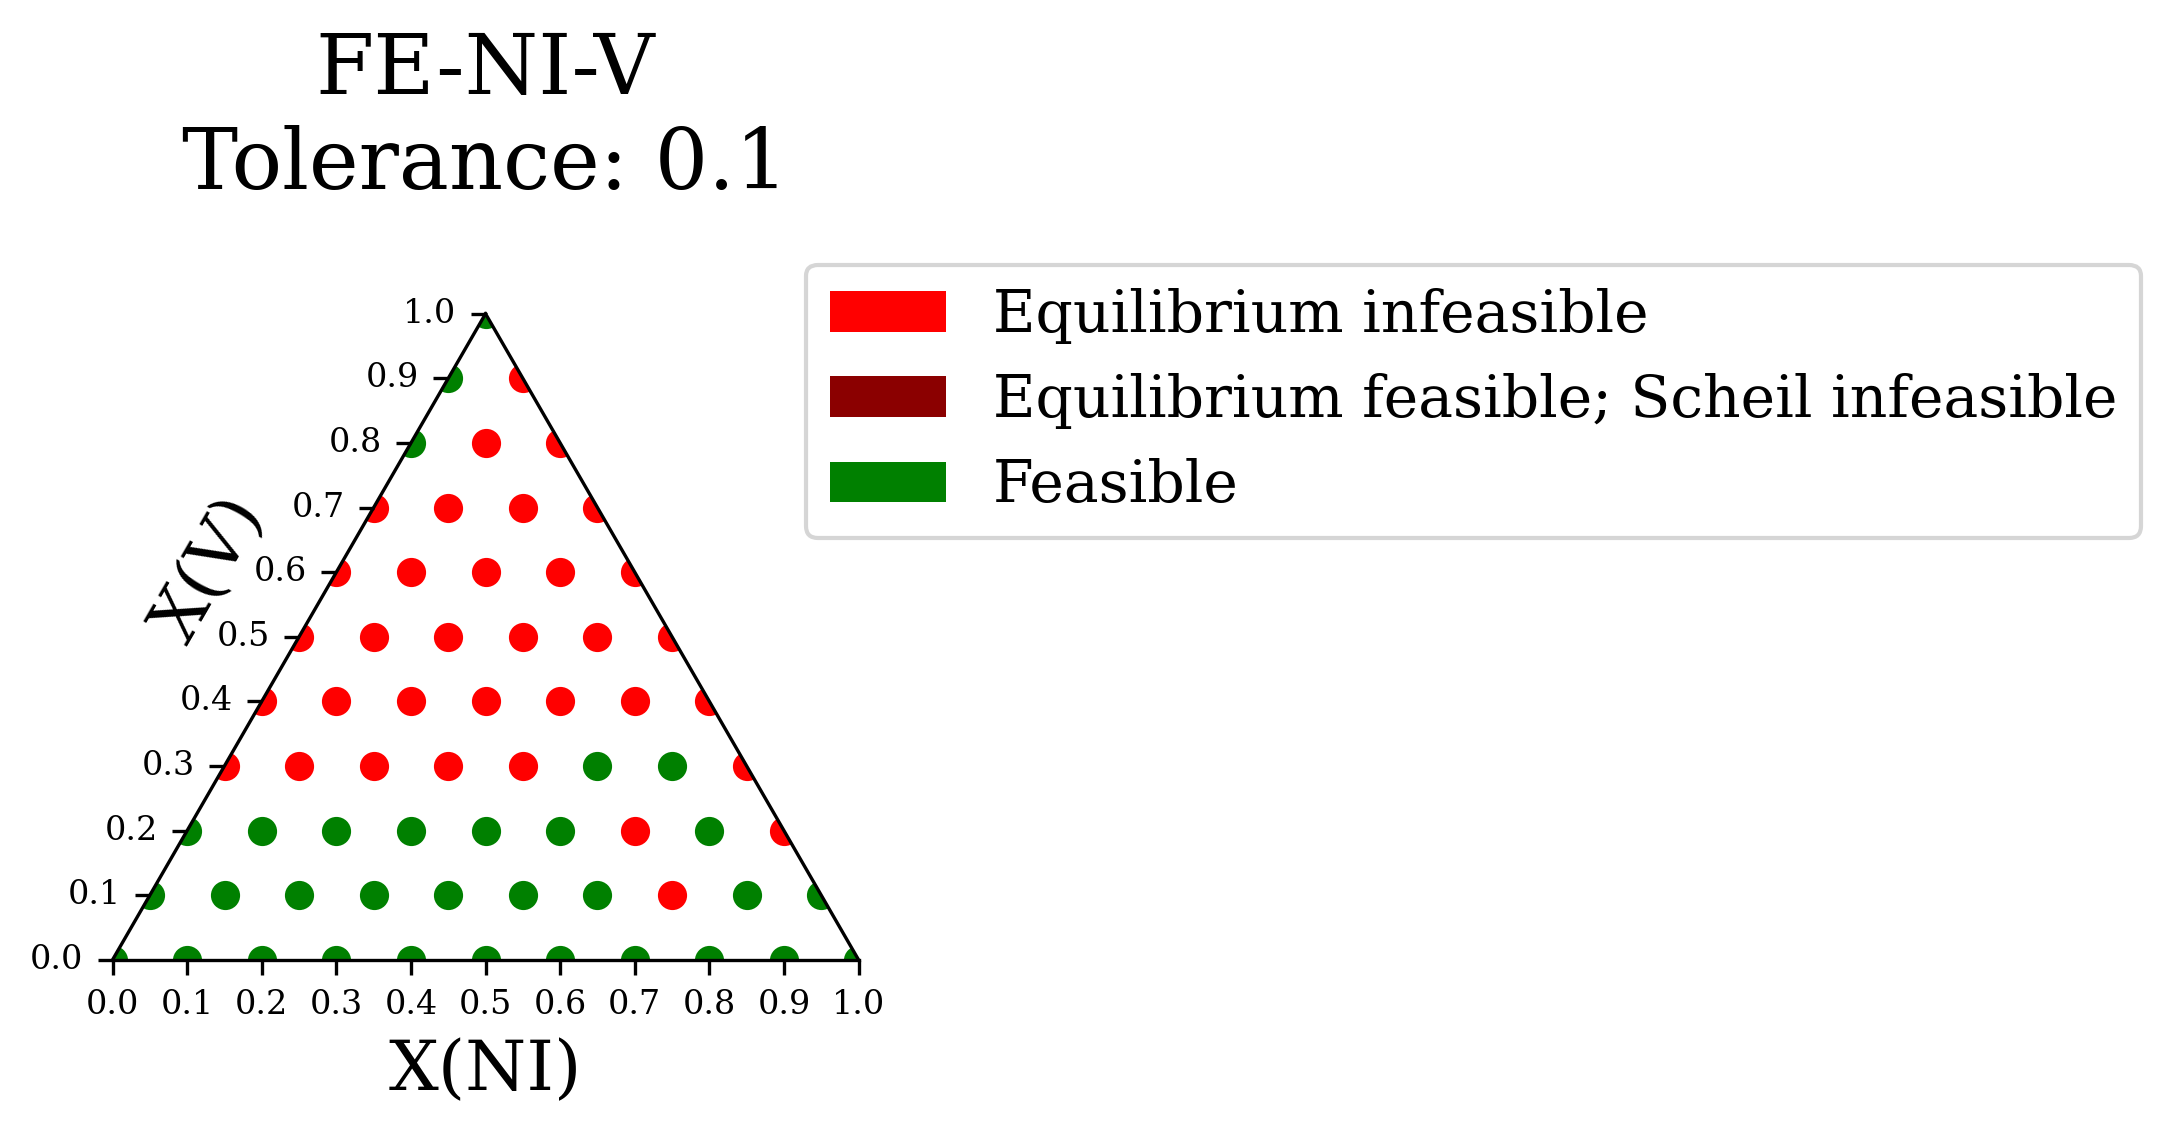

In [7]:
# Plot feasibility on a ternary triangular diagram
indep_comp_vars = [v.X(ic) for ic in indep_comps]
handles = [
    mpl.patches.Patch(facecolor='red'),
    mpl.patches.Patch(facecolor='darkred'),
    mpl.patches.Patch(facecolor='green'),
]
labels = [
    'Equilibrium infeasible',
    'Equilibrium feasible; Scheil infeasible',
    'Feasible',
]

fig = plt.figure()
ax = fig.add_subplot(projection='triangular')
for composition, eq_result, scheil_result in zip(compositions_list, eq_results, scheil_results):
    x_plot, y_plot = composition[indep_comp_vars[0]], composition[indep_comp_vars[1]]


    eq_is_feasible = get_amount_disallowed_phases(eq_result, allowed_phases).max() < tolerance_deleterious_phases
    if not eq_is_feasible:
        ax.scatter(x_plot, y_plot, label='Equilibrium infeasible', c='red')
        continue

    assert scheil_result is not None, "Scheil calculation must exist to determine feasibility if equilibrium is feasible."
    scheil_is_feasible = get_amount_disallowed_phases_scheil(scheil_result, allowed_phases) < tolerance_deleterious_phases
    if not scheil_is_feasible:
        ax.scatter(x_plot, y_plot, label='Equilibrium feasible; Scheil infeasible', c='darkred')
        continue

    ax.scatter(x_plot, y_plot, label='Equilibrium and Scheil feasible', c='green')

fmtted_comps = '-'.join(sorted(set(comps) - {'VA'}))
ax.set_title(f"{fmtted_comps}\nTolerance: {tolerance_deleterious_phases}")
ax.set_xlabel(f'X({indep_comps[0]})')
ax.set_ylabel(f'X({indep_comps[1]})', labelpad=-50)
fig.legend(handles=handles, labels=labels, loc='lower left', bbox_to_anchor=(0.45, 0.5))
ax.tick_params(labelsize=8)

fig.savefig(os.path.join(OUTDIR, f'{fmtted_comps}.pdf'), bbox_inches='tight')